<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/kitti_3D_BBOX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the data

In [8]:
#https://drive.google.com/file/d/1OnPK__6VqIaNCaJucgdtlTcEqGZ0dQOJ/view?usp=sharing
import gdown
url = 'https://drive.google.com/uc?id=1OnPK__6VqIaNCaJucgdtlTcEqGZ0dQOJ'
gdown.download(url,'kitti.zip',quiet=True) 
!unzip -q kitti.zip 

replace kitti/object/training/calib/000005.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


2D Kitti image, depth, camera pose to 3D point cloud:

In [ ]:
??

Point Cloud to 3D BBOX Annotations:

In [ ]:
??

Visualization of 3D BBOX from Annotations:

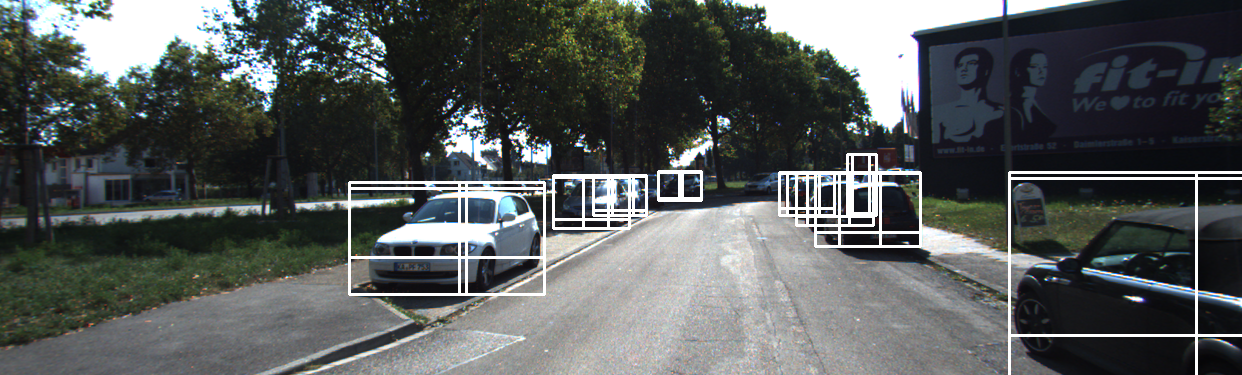

In [7]:
import os
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

def draw_bbox(img_path,label_path,calib_path,draw_3D=False):

    '''
    This function realizes drawing all the boungding boxes on the image
    The meanings of input parameters
    img_path(str): the path to get image
    label_path(str): the path to get label annotations
    calib_path(str): the path to get calib parameters
    draw_3D(bool): determine to draw 3D bbox or 2D bbox >> True for 3D/False for 2D
    '''

    img =cv2.imread(img_path)

    '''
    Here we will obtain calib parameters
    P2 is to project 3D points into 2D image of camera2
    In the calib file P2 includes 12 parameters and we reshape them into 3x4 array
    
    R0_rect is to rectify camera0
    In the file R0_rect includes 9 parameters and we reshape them into 4x4 array by padding with 0s while the right-bottom one is 1.0
    '''
    with open(calib_path) as calib_obj:
        calib_lines = calib_obj.readlines()
    for calib_line in calib_lines:
        calibs = calib_line.split(' ')
        if 'P2' in calibs[0]:
            P2_str = calibs[1:]
            P2_matrix = np.array(P2_str,dtype=float).reshape(3,4)
        elif 'R0_rect' in calibs[0]:
            R0_rect_str = calibs[1:]
            R0_rect_matrix = np.zeros((4,4))
            R0_rect_3x3 = np.array(R0_rect_str,dtype=float).reshape(3,3)
            for i in range(0,3):
                R0_rect_matrix[i][0:3] = R0_rect_3x3[i]
            R0_rect_matrix[3][3] = 1.0
        else:
            continue
    
    '''
    Then we get labels from annotation file.
    We mainly focus on 2D bounding box coordinates, 3D information: dimensions and locations and rotation angle
    Dimensions: height, width, length
    locations: X, Y, Z in camera0 frame
    rotation angle: r_y
    Here I calculate coordinates of 8 vertices by using Triangle Relations and they can also be gotten by coordinate transformation
    '''
    with open(label_path) as label_obj:
        label_lines = label_obj.readlines()
    for label_line in label_lines:
        contents = label_line.split(' ')
        if 'DontCare' in contents:
            continue
        else:
            label_name = contents[0]
            bbox_2d = [float(contents[i]) for i in range(4,8)]
            height, width, length = float(contents[8]),float(contents[9]),float(contents[10])
            X,Y,Z = float(contents[11]), float(contents[12]), float(contents[13])
            r_y = float(contents[14])
            cos = math.cos(r_y)
            sin = math.sin(r_y)

            #compute the bottom four vertices through triangle relations
            pt0_x = X + 0.5*width*sin + 0.5*length*cos
            pt0_z = Z + 0.5*width*cos - 0.5*length*sin

            pt3_x = X + 0.5*width*sin - 0.5*length*cos
            pt3_z = Z + 0.5*width*cos + 0.5*length*sin

            pt2_x = pt3_x - width*sin
            pt2_z = pt3_z - width*cos

            pt1_x = pt0_x - width*sin
            pt1_z = pt0_z - width*cos

            x = [pt0_x,pt1_x,pt2_x,pt3_x]
            z = [pt0_z,pt1_z,pt2_z,pt3_z]

            bbox_3d_vertex = np.zeros((8,4,1))
            for i in range(0,8):
                if i > 3:
                    j = i-4
                    y = Y - height
                else:
                    j = i
                    y = Y
                bbox_3d_vertex[i] = [[x[j]],[y],[z[j]],[1]]
            #print(label_name,'\n',bbox_3d_vertex)
            
            #obtain coordinates of vertices in image frame through projection transformation
            point_in_P2_img = []
            for idex in range(0,8):
                point_rect = np.dot(R0_rect_matrix,bbox_3d_vertex[idex])
                point_proj = np.dot(P2_matrix,point_rect)
                projection = [int(point_proj[0]/point_proj[2]),int(point_proj[1]/point_proj[2])]
                point_in_P2_img.append(projection)
                #print(idex,'\n',point_in_P2_img[idex])

            color = (255,255,255) #bgr
            thick = 2
            
            #These four vertices are enough to form 3D bounding boxes on 2D image
            x0,y0 = point_in_P2_img[0]
            x2,y2 = point_in_P2_img[2]
            x5,y5 = point_in_P2_img[5]
            x7,y7 = point_in_P2_img[7]
            
            if draw_3D:
                #draw 3D bounding boxes
                cv2.rectangle(img,(x0,y0),(x2,y2),color,thick)
                cv2.rectangle(img,(x0,y0),(x7,y7),color,thick)
                cv2.rectangle(img,(x0,y0),(x5,y5),color,thick)
                cv2.rectangle(img,(x2,y2),(x7,y7),color,thick)
                cv2.rectangle(img,(x2,y2),(x5,y5),color,thick)
                cv2.rectangle(img,(x5,y5),(x7,y7),color,thick)
            else:
                #draw 2D bounding boxes
                cv2.rectangle(img,(int(bbox_2d[0]),int(bbox_2d[1])),(int(bbox_2d[2]),int(bbox_2d[3])),(0,0,255),2)

    #show image with bounding box and press Q to close image visulization
    cv2_imshow(img)
    if cv2.waitKey() == ord('Q'):
        cv2.destroyAllWindows()
            

'''
Folder path
The structure is:
kitti
    --object
        --training
            --calib
                all calib files in txt
            --image_2
                all image files in png
            --label_2
                all label files in txt
Following this structure, kitti_path is the only one required to change
''' 
kitti_path = 'kitti/object'
train_path = kitti_path + '/training'
img_dir = train_path + '/image_2/'
label_dir = train_path + '/label_2/'
calib_dir = train_path + '/calib/'

'''
img_id is used to choose image
Here I set this to 10 which represents image file 000010.png
It can be changed to any image within the training set which can be downloaded from the Kitti officail websit
And it should be input within the range of range(0,7481) with the least number of digits
For example if the name of image file is 000456.png then the img_id should be img_id=456
'''

img_id = 10

if img_id not in range(0,7481):
    img_id = 10

file_name = (6-len(str(img_id)))*'0' + str(img_id)
png_file = file_name + '.png'
txt_flie = file_name + '.txt'

'''
With the img_id, the paths that access to corresponding calib file, label file and image file will be formed here
and these paths will be passed to the function above to draw bounding box
'''
img_path = os.path.join(img_dir,png_file)
label_path = os.path.join(label_dir,txt_flie)
calib_path = os.path.join(calib_dir,txt_flie)


if __name__ == '__main__':
    #call the function
    #changing the value of draw_3D can change the type of bounding box
    draw_bbox(img_path,label_path,calib_path,draw_3D=True)